In [1]:
from pandas import read_csv
from datetime import datetime
# load data
dataset = read_csv('Main_Raw.csv', index_col=0)
# manually specify column names
#dataset.columns = []
dataset['DateTime'] = [datetime.strptime(d, "%Y-%m-%d %H:%M:%S") for d in dataset["DateTime"]]
dataset.set_index('DateTime', inplace=True)
#dataset.index.name = 'date'
# drop the first 24 hours
#dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('energy.csv')

                     TotalUsage  Month  TemperatureF  Humidity  Hour_y  \
DateTime                                                                 
2016-01-01 00:00:00   19.843233      1          50.0      63.0       0   
2016-01-01 01:00:00   18.462483      1          49.8      63.0       1   
2016-01-01 02:00:00   17.414167      1          48.9      61.0       2   
2016-01-01 03:00:00   15.914683      1          48.6      61.0       3   
2016-01-01 04:00:00   19.195933      1          47.7      63.0       4   

                     Minute_y  Day_y  Weekend  Holiday  
DateTime                                                
2016-01-01 00:00:00         0      6        0        0  
2016-01-01 01:00:00        60      6        0        0  
2016-01-01 02:00:00       120      6        0        0  
2016-01-01 03:00:00       180      6        0        0  
2016-01-01 04:00:00       240      6        0        0  


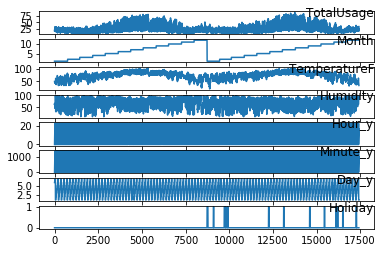

(17429, 8)

In [2]:
from pandas import read_csv
from matplotlib import pyplot
%matplotlib inline
# load dataset
dataset = read_csv('energy.csv', header=0, index_col=0)
del dataset['Weekend']
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 4, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()
dataset.shape

(17428, 16)
(14400, 8) 14400 (14400,)
(14400, 1, 8) (14400,) (3028, 1, 8) (3028,)
Train on 14400 samples, validate on 3028 samples
Epoch 1/20
 - 1s - loss: 0.0939 - val_loss: 0.1895
Epoch 2/20
 - 0s - loss: 0.0970 - val_loss: 0.1591
Epoch 3/20
 - 0s - loss: 0.0740 - val_loss: 0.1333
Epoch 4/20
 - 0s - loss: 0.0543 - val_loss: 0.0898
Epoch 5/20
 - 0s - loss: 0.0443 - val_loss: 0.0521
Epoch 6/20
 - 0s - loss: 0.0413 - val_loss: 0.0412
Epoch 7/20
 - 0s - loss: 0.0397 - val_loss: 0.0370
Epoch 8/20
 - 0s - loss: 0.0379 - val_loss: 0.0348
Epoch 9/20
 - 0s - loss: 0.0365 - val_loss: 0.0340
Epoch 10/20
 - 0s - loss: 0.0358 - val_loss: 0.0339
Epoch 11/20
 - 0s - loss: 0.0355 - val_loss: 0.0339
Epoch 12/20
 - 0s - loss: 0.0353 - val_loss: 0.0343
Epoch 13/20
 - 0s - loss: 0.0353 - val_loss: 0.0345
Epoch 14/20
 - 0s - loss: 0.0352 - val_loss: 0.0347
Epoch 15/20
 - 0s - loss: 0.0352 - val_loss: 0.0349
Epoch 16/20
 - 0s - loss: 0.0353 - val_loss: 0.0351
Epoch 17/20
 - 0s - loss: 0.0352 - val_loss: 0

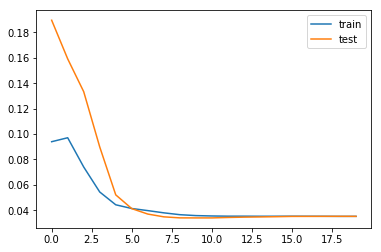

Test RMSE: 3.541


In [11]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# load dataset
dataset = read_csv('energy.csv', header=0, index_col=0)
del dataset['Humidity']
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_hours = 1
n_features = 8
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)

# split into train and test sets
values = reframed.values
n_train_hours = 600 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_z = inv_y
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

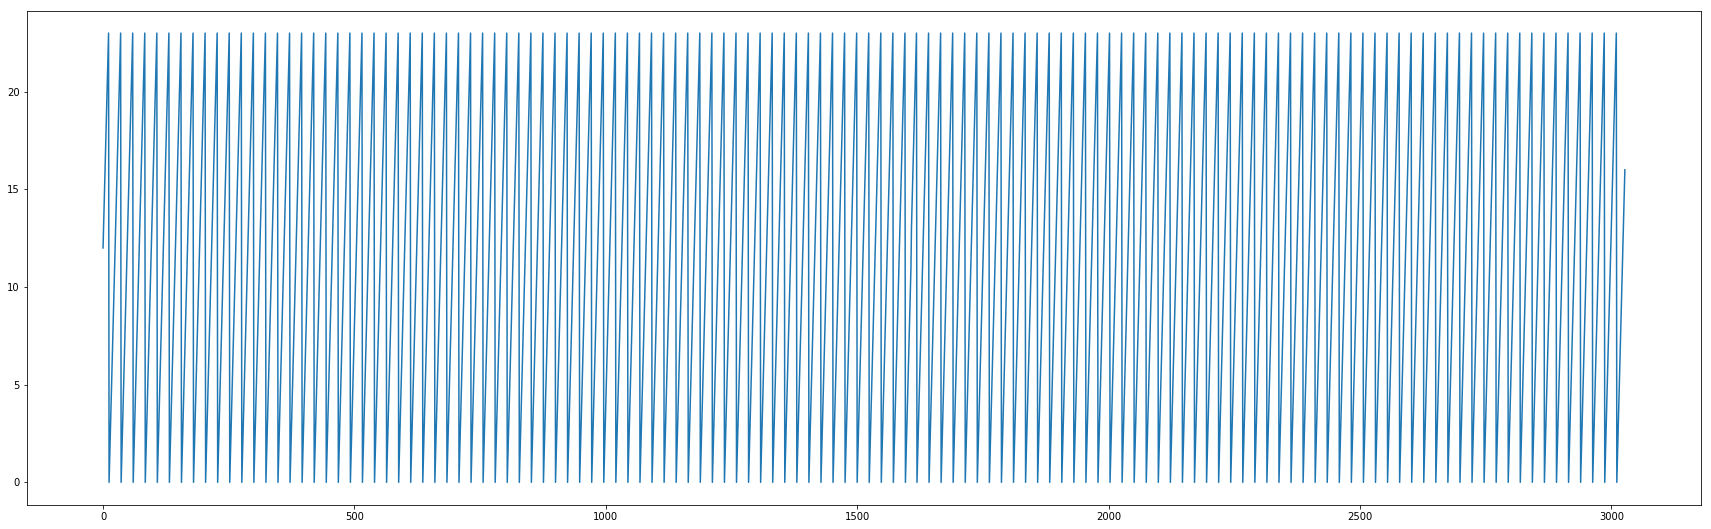

In [5]:
fig = pyplot.figure(figsize=(30,20))
ax2 = fig.add_subplot(211)
ax2.plot(inv_z[:,3])

[27.708183 25.607483 25.60072  ... 29.153448 30.28535  33.841385]


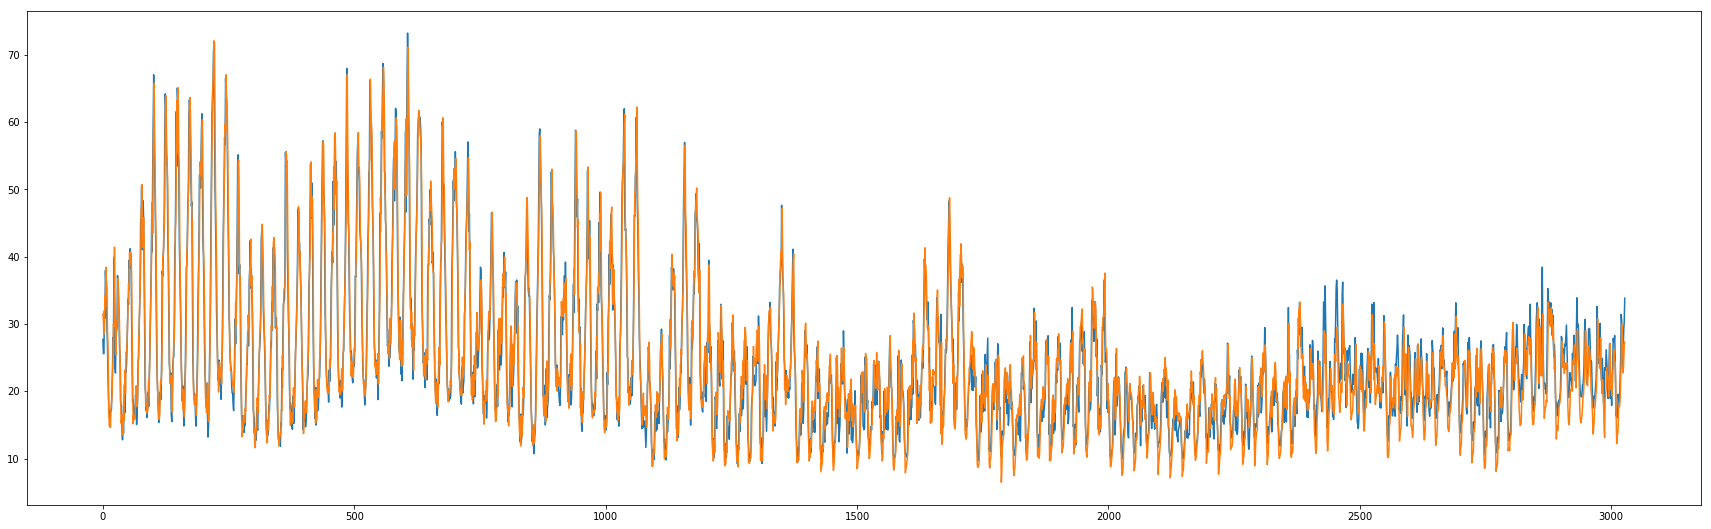

In [6]:
inv_y.shape
inv_yhat.shape
fig = pyplot.figure(figsize=(30,20))
ax1 = fig.add_subplot(211)
ax1.plot(inv_y)
ax1.plot(inv_yhat)
print(inv_y)


(17426, 36)
(14400, 27) 14400 (14400,)
(14400, 3, 9) (14400,) (3026, 3, 9) (3026,)
Train on 14400 samples, validate on 3026 samples
Epoch 1/50
 - 1s - loss: 0.0831 - val_loss: 0.1174
Epoch 2/50
 - 1s - loss: 0.0647 - val_loss: 0.0835
Epoch 3/50
 - 1s - loss: 0.0522 - val_loss: 0.0619
Epoch 4/50
 - 1s - loss: 0.0432 - val_loss: 0.0440
Epoch 5/50
 - 1s - loss: 0.0376 - val_loss: 0.0384
Epoch 6/50
 - 1s - loss: 0.0369 - val_loss: 0.0387
Epoch 7/50
 - 1s - loss: 0.0374 - val_loss: 0.0380
Epoch 8/50
 - 1s - loss: 0.0372 - val_loss: 0.0375
Epoch 9/50
 - 1s - loss: 0.0362 - val_loss: 0.0371
Epoch 10/50
 - 1s - loss: 0.0357 - val_loss: 0.0367
Epoch 11/50
 - 1s - loss: 0.0352 - val_loss: 0.0364
Epoch 12/50
 - 1s - loss: 0.0348 - val_loss: 0.0363
Epoch 13/50
 - 1s - loss: 0.0346 - val_loss: 0.0362
Epoch 14/50
 - 1s - loss: 0.0343 - val_loss: 0.0361
Epoch 15/50
 - 1s - loss: 0.0341 - val_loss: 0.0353
Epoch 16/50
 - 1s - loss: 0.0340 - val_loss: 0.0352
Epoch 17/50
 - 1s - loss: 0.0338 - val_loss: 

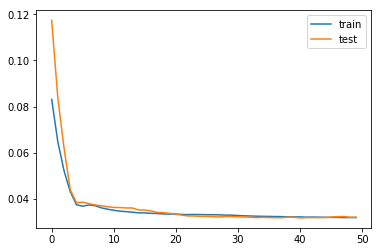

Test RMSE: 3.313


In [7]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# load dataset
dataset = read_csv('energy.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_hours = 3
n_features = 9
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)

# split into train and test sets
values = reframed.values
n_train_hours = 600 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -8:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -8:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)